# Projet statistique descriptive 



In [1]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import * 

# chemin vers la donnee 
data_dir = 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive/'
filelist = glob.glob(data_dir + '*.h5')
filelist

['C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03_dask.h5']

In [2]:
from tabata import Opset

In [3]:
df_opset1=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5')
df_opset2=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5')
df_opset3=Opset('C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5')

In [4]:
df_opset1

OPSET 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\Aircraft_01.h5' de 1002 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT [ft]
        phase surlignée   : phase   = None

In [5]:
df_opset1.plot()

In [6]:
type(df_opset2)

tabata.opset.Opset

In [7]:
df_opset2.plot()

In [8]:
df_opset3.plot()

In [9]:
def eliminate_records(df):
    alt_min=df['ALT [ft]'].min()
    alt_max=df['ALT [ft]'].max()
    alt_range=alt_max-alt_min
    bol=False
    
    if alt_range<15000:
        bol=True
    return bol
    
    

In [10]:
#on cree notre dataframe avec DASK
ddf1 = lire_hdf_dask(filelist[0], repertoire= data_dir)
#on récupère une liste de booleen où chaque composante fait reférance à une partition 
I = ddf1.map_partitions(lambda df: eliminate_records(df)).compute()
#on sélectione dans un nouveau dataframe les partitions qui ne sont pas mauvaise
DDF1=ddf1.partitions[I==False]
# on normalise toute les données excepté les variables booleen 
ddf_norm1 = DDF1.map_partitions(lambda df : normalize(df))

ddf2 = lire_hdf_dask(filelist[2], repertoire= data_dir)
I = ddf2.map_partitions(lambda df: eliminate_records(df)).compute()
DDF2=ddf2.partitions[I==False]
ddf_norm2 = DDF2.map_partitions(lambda df : normalize(df))

ddf3 = lire_hdf_dask(filelist[3], repertoire= data_dir)
I = ddf3.map_partitions(lambda df: eliminate_records(df)).compute()
DDF3=ddf3.partitions[I==False]
ddf_norm3 = DDF3.map_partitions(lambda df : normalize(df))

C:\Users\felix\PycharmProjects\pythonProject1\projet_lacaille\stats_descriptive_project\notebooks\..\src\manipulate_dataframe.py:19: RuntimeWarning:

invalid value encountered in divide

C:\Users\felix\PycharmProjects\pythonProject1\projet_lacaille\stats_descriptive_project\notebooks\..\src\manipulate_dataframe.py:19: RuntimeWarning:

invalid value encountered in divide

C:\Users\felix\PycharmProjects\pythonProject1\projet_lacaille\stats_descriptive_project\notebooks\..\src\manipulate_dataframe.py:19: RuntimeWarning:

invalid value encountered in divide



In [11]:
df=ddf1.partitions[1].compute()
df['ALT [ft]'].min()

-134.462575892

In [12]:
ddf_norm2.head()

,ALT,EGT_1,EGT_2,FMV_1,FMV_2,HPTACC_1,HPTACC_2,M,N1_1,N1_2,...,VIB_AN1_1,VIB_AN1_2,VIB_AN2_1,VIB_AN2_2,VIB_BN1_1,VIB_BN1_2,VIB_BN2_1,VIB_BN2_2,VSV_1,VSV_2
record_00,,,,,,,,,,,,,,,,,,,,,
0,-1.134103,-3.447952,-3.667389,-2.28672,-2.364025,-1.128226,-1.261854,-1.339298,-1.854991,-1.873735,...,-1.22466,-1.070851,-1.455161,-0.995082,-1.3565,-1.18976,-1.749496,-1.453541,1.376408,1.386277
1,-1.134103,-3.447952,-3.667389,-2.28672,-2.364025,-1.128226,-1.261854,-1.339298,-1.854991,-1.873735,...,-1.22466,-1.070851,-1.455161,-0.995082,-1.3565,-1.18976,-1.749496,-1.453541,1.376408,1.386277
2,-1.134103,-3.447952,-3.674029,-2.28672,-2.364025,-1.126343,-1.261854,-1.339298,-1.854991,-1.873735,...,-1.22466,-1.070851,-1.455161,-0.995082,-1.3565,-1.18976,-1.749496,-1.453541,1.376408,1.390019
3,-1.134103,-3.447952,-3.667389,-2.28672,-2.364025,-1.128226,-1.259411,-1.339298,-1.854991,-1.873735,...,-1.22466,-1.070851,-1.455161,-0.995082,-1.3565,-1.18976,-1.749496,-1.453541,1.376408,1.386277
4,-1.134103,-3.447952,-3.667389,-2.28672,-2.364025,-1.128226,-1.261854,-1.339298,-1.854991,-1.873735,...,-1.22466,-1.070851,-1.455161,-0.995082,-1.3565,-1.18976,-1.749496,-1.453541,1.376408,1.386277


# appliquer un filtrage sur l'egt pour recuperer les tendances
-> Quand est t'il du bruit ? ne risquons nous pas d'interpréter du bruit pour quelque chose de significatif


#calcul de la corelation entre l'usure et la vitesse d'altitude 
premièrement il faut repérer les valeur de vittesse de montée
Attention il faut fuiltrer les les valeurs pour éviter le parasitage 
on peut récupérer le temps passé a une altitude supérieur à un montant fixé 
et ainssi remarqueé une corélation entre ce temps fixée et une baisse de la marge EGT 
Attention l'egt est une valeur qu'on devra aussi filtrer 


Il va falloir peut être modifier la fonction deriv_glissante lorsque qu'on passera à l'analyse de chaque record 

In [13]:
def deriv_glissante(df):
    #on cree une fonction qui prend un data frame qui l'augment de la valeur dy et qui renvoit  un nouveau dataframe contenant que le monté 
    #ATTENTION LA FONCTION PRENDS EN ENTREE DES DONNEES NORMALISE
    dy=np.zeros(len(df))
    y = df['ALT'].rolling(window = 20).mean()
    I = range(y.index[0], y.index[-1],20)
    dy[0:len(I)-1] = y[I[1:]].values- y[I[:-1]].values
    df['dy']=dy
    df_monte=df[df['dy']>0.01]
    I4=np.zeros(len(df_monte))
    I4[5:]=df_monte.index[5:]==(df_monte.index+5)[:-5]
    I4[:5]=1
    df_monte2=df_monte[I4==1]
    


    return [df_monte2]

In [14]:
DF_monte=ddf_norm1.map_partitions(lambda df:deriv_glissante(df))
DF_monte

Dask Series Structure:
npartitions=996
    string
       ...
     ...  
       ...
       ...
dtype: string
Dask Name: to_pyarrow_string, 5 graph layers

In [15]:
DF_monte.partitions[10].compute()

StopIteration: 

7278

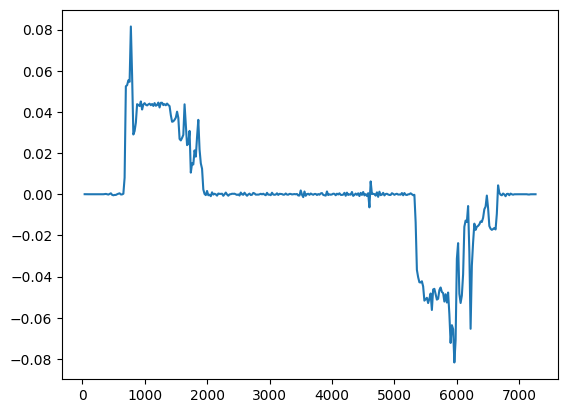

In [16]:
df=ddf_norm1.partitions[10].compute()
y = df['ALT'].rolling(window = 20).mean()
I = range(y.index[0], y.index[-1],20)
dy = y[I[1:]].values- y[I[:-1]].values
plt.plot(I[1:], dy)
len(y)

In [17]:
df12=ddf_norm1.partitions[100].compute()

[df_monte]=deriv_glissante(df12)


#plt.plot(df12['EGT_1'][I_monte])


#duree de la monte
duree=len(df_monte2)*20
#Indice monte
I_monte=df_monte2.index*20
#calcul de l'egt max pour chaque moteur pendant la monté
EGT_max_monte1=df['EGT_1'][I_monte].max()
EGT_max_monte2=df['EGT_2'][I_monte].max()
EGT_max_monte=max(EGT_max_monte1,EGT_max_monte2)

NameError: name 'df_monte2' is not defined

peut paralléliser avec dask 

In [ ]:
duree11=[]
EGT_max_monte1=[]
I=[]
for i in range (0,990,10):
    I.append(i)
    df11=ddf_norm1.partitions[i].compute()
    #df22=ddf_norm2.partitions[i].compute()
    #df22=ddf_norm3.partitions[i].compute()
    [df_monte11]=deriv_glissante(df11)
    #[df_monte22]=deriv_glissante(df22)
    #[df_monte33]=deriv_glissante(df33)
  
    duree11.append(len(df_monte11)*20)
    #duree22=len(df_monte22)*20
    #duree33=len(df_monte33)*20

    #Indice monte
    I_monte11=df_monte11.index*20
    #I_monte22=df_monte22.index*20
    #I_monte33=df_monte33.index*20
    #calcul de l'egt max pour chaque moteur pendant la monté
    EGT_max_monte11=df['EGT_1'][I_monte11].max()
    EGT_max_monte21=df['EGT_2'][I_monte11].max()
    
    #EGT_max_monte12=df['EGT_1'][I_monte22].max()
    #EGT_max_monte22=df['EGT_2'][I_monte22].max()
    
    #EGT_max_monte13=df['EGT_1'][I_monte33].max()
    #EGT_max_monte23=df['EGT_2'][I_monte33].max()
    
    EGT_max_monte1.append(max(EGT_max_monte11,EGT_max_monte21))
    #EGT_max_monte2.append(max(EGT_max_monte12,EGT_max_monte22))    
    #EGT_max_monte3.append(max(EGT_max_monte13,EGT_max_monte23))    


In [ ]:
plt.scatter(duree11,EGT_max_monte1)

In [ ]:
plt.scatter(duree11,EGT_max_monte1)

# une manière alternative de calculer le temps paser en monter et de selectionner parmis les montés la vittesse en mac/S
Attention vérifié qu'i l n'y a pas de dépendance entre l'angle de l'avion et la vittesse mesuré ( je ne pense pas )

In [ ]:
# peut on prédire l'egt en fonction des température et des autre valeurs 

In [ ]:
#peut on analyser les données manquantes et peut être apporter un corectif  